## Summary

In this supervised machine learning task, I use the [Ajio Fashion Clothing](https://www.kaggle.com/datasets/manishmathias/ajio-clothing-fashion) dataset, available on Kaggle, to obtain a model predicting the prices of the clothing articles. Aspects of the project include: data exploration, cleansing and analysis, feature engineering, and modeling. Within the machine learning step are: using pipelines, TFIDFVectorization, target encoding, k-fold cross validation, Grid Search CV hyperparameter tuning, and simultaneous grid search for multiple models. The decision tree model yielded the best results. However, modeling can be improved with additional information on customer demographics and more granular clothing details.

## Loading Libraries and Dataset

In [1]:
#Import libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import random
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVR
from sklearn.svm import SVR
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold
from statistics import mean
from sklearn.metrics import mean_squared_error

In [2]:
#Load and view the dataframe

dtf = pd.read_csv('C:/Users/volvo/Documents/Ajio_Fashion_Clothing.csv', encoding='latin-1')
dtf.head(3)

,Product_URL,Brand,Description,Id_Product,URL_image,Category_by_gender,Discount Price (in Rs.),Original Price (in Rs.),Color
0,https://www.ajio.com/netplay-checked-polo-t-sh...,netplay,Checked Polo T-shirt,441137362002,https://assets.ajio.com/medias/sys_master/root...,Men,559,699,white
1,https://www.ajio.com/netplay-tapered-fit-flat-...,netplay,Tapered Fit Flat-Front Trousers,441124497006,https://assets.ajio.com/medias/sys_master/root...,Men,720,"1,499",navy
2,https://www.ajio.com/the-indian-garage-co-stri...,the-indian-garage-co,Striped Slim Fit Shirt with Patch Pocket,460453612003,https://assets.ajio.com/medias/sys_master/root...,Men,495,"1,649",white


## Exploratory Analysis

In [3]:
dtf.shape

(367172, 9)

In [4]:
dtf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367172 entries, 0 to 367171
Data columns (total 9 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   Product_URL              367172 non-null  object
 1   Brand                    367172 non-null  object
 2   Description              367172 non-null  object
 3   Id_Product               367172 non-null  int64 
 4   URL_image                367172 non-null  object
 5   Category_by_gender       367172 non-null  object
 6   Discount Price (in Rs.)  367172 non-null  object
 7   Original Price (in Rs.)  367172 non-null  object
 8   Color                    367172 non-null  object
dtypes: int64(1), object(8)
memory usage: 25.2+ MB


In [5]:
dtf.describe()

,Id_Product
count,3.671720e+05
mean,4.595705e+11
std,2.349409e+10
min,4.100129e+11
25%,4.609615e+11
50%,4.626215e+11
75%,4.638856e+11
max,4.601102e+12


## Data Cleaning

In [6]:
#This function does the data cleaning process

def cleansing(df):
    df.columns = df.columns.str.lower()
    df.rename(columns = {
        'product_url':'prod_url', 'id_product':'prod_id','url_image':'image_url', 'category_by_gender':'gender',
        'discount price (in rs.)':'disc_price_rupees', 'original price (in rs.)':'orig_price_rupees'
        }, inplace = True)
    df['orig_price_rupees'] = df['orig_price_rupees'].apply(str)
    df['orig_price_rupees'] = df['orig_price_rupees'].str.replace(",","")
    df['orig_price_rupees'] = df['orig_price_rupees'].astype(float)
    df['disc_price_rupees'] = df['disc_price_rupees'].apply(str)
    df['disc_price_rupees'] = df['disc_price_rupees'].str.replace(",","")
    df['disc_price_rupees'] = df['disc_price_rupees'].astype(float)
    
    #Calculate currency in USD
    df['orig_price_usd'] = df.apply(lambda row: row.orig_price_rupees * 0.013, axis=1)
    df['disc_price_usd'] = df.apply(lambda row: row.disc_price_rupees * 0.013, axis=1)
    
    #Drop columns not using in analysis
    global_df = df.drop(columns=['prod_url', 'image_url', 'disc_price_rupees', 'orig_price_rupees'])
    
    global_df['brand'] = global_df['brand'].str.replace('-', '_')
    
    #Convert all string columns to lowercase string texts
    global_df = global_df.applymap(lambda s: s.lower() if type(s) == str else s)
    return global_df

In [7]:
global_df = cleansing(dtf)

In [8]:
global_df.brand.nunique()

1975

In [9]:
global_df.gender.unique()

array(['men', 'women'], dtype=object)

## Feature Engineering

In [10]:
#Assign clothes categories to specified general descriptions
def clothing_category(row):  
    clothes = ['shirt', 'blouse', 'trousers', 'jeans', 'pants', 'dress', 'shorts', 'skirt', 'sweater', 'saree', 'kurta', 'jogger', 
               'jacket', 'vest', 'blazer', 'hoodie', 'socks', 'pullover', 'brief', 'hipster', 'boxer', 'suit', 'shoes', 'cap', 
               'trunks', 'top', 'bottom', 'tracksuit', 'legging', 'tie', 'shawl', 'coat', 'shrug', 'dungaree', 'culotte']
    for item in clothes:
        if item in row['description']:
            return item
        else:
            pass

In [11]:
#Apply clothing_category function, assigning the result to the gen_desc column
global_df['gen_desc'] = global_df.apply(lambda row: clothing_category(row), axis=1)
global_df.head(3)

,brand,description,prod_id,gender,color,orig_price_usd,disc_price_usd,gen_desc
0,netplay,checked polo t-shirt,441137362002,men,white,9.087,7.267,shirt
1,netplay,tapered fit flat-front trousers,441124497006,men,navy,19.487,9.360,trousers
2,the_indian_garage_co,striped slim fit shirt with patch pocket,460453612003,men,white,21.437,6.435,shirt


In [12]:
global_df['gen_desc'].unique()

array(['shirt', 'trousers', 'jeans', 'pants', 'shorts', None, 'jogger',
       'jacket', 'brief', 'pullover', 'vest', 'blazer', 'hoodie', 'socks',
       'tie', 'boxer', 'bottom', 'trunks', 'suit', 'kurta', 'shoes',
       'sweater', 'cap', 'shawl', 'legging', 'coat', 'top', 'dungaree',
       'dress', 'shrug', 'blouse', 'saree', 'culotte', 'skirt', 'hipster'],
      dtype=object)

Analyze the dataframe to assign general descriptions to additional items.

In [13]:
global_df.head(25)

,brand,description,prod_id,gender,color,orig_price_usd,disc_price_usd,gen_desc
0,netplay,checked polo t-shirt,441137362002,men,white,9.087,7.267,shirt
1,netplay,tapered fit flat-front trousers,441124497006,men,navy,19.487,9.360,trousers
2,the_indian_garage_co,striped slim fit shirt with patch pocket,460453612003,men,white,21.437,6.435,shirt
3,performax,heathered crew-neck t-shirt,441036730003,men,charcoal,7.787,4.277,shirt
4,john_players_jeans,washed skinny fit jeans with whiskers,441128531011,men,jetblack,12.987,11.687,jeans
5,dennislingo_premium_attire,slim fit shirt with patch pocket,462323964055,men,olive,24.037,8.892,shirt
6,dennislingo_premium_attire,striped slim fit shirt,461119026005,men,black,32.487,9.100,shirt
7,teamspirit,track pants with contrast taping,441031716014,men,ltblue,6.487,5.447,pants
8,performax,fastdry active crew-neck t-shirt,441128501060,men,jetblack,6.487,4.862,shirt
9,ardeur,pack of 2 shorts with insert pocket,461730457003,men,black,25.974,6.500,shorts


In [14]:
none_df = global_df[global_df['gen_desc'].isnull()]
none_df

,brand,description,prod_id,gender,color,orig_price_usd,disc_price_usd,gen_desc
15,netplay,slim fit flat-front chinos with insert pockets,441121060055,men,green,16.887,10.127,None
16,netplay,mid-rise flat-front cropped slim fit chinos,441121060030,men,ltgrey,16.887,10.127,None
23,netplay,tapered fit flat-front chinos,441124499010,men,stone,19.487,9.360,None
25,netplay,cropped slim fit chinos with slip pockets,441131542006,men,green,16.887,12.662,None
53,netplay,flat-front tapered chinos,441121065020,men,jetblack,19.487,9.555,None
...,...,...,...,...,...,...,...,...
367128,clovia,bra & panty set lace panel,461065035008,women,black,14.274,4.706,None
367141,fusion,printed tunic with contrast panel,441141681005,women,wine,16.887,16.887,None
367143,indie_picks,handloom pochampally woven ikat cotton dupatta,469065731001,women,grey,38.987,19.500,None
367150,blanc_9,checked nightwear set with elasticated waistband,464293497005,women,grey,31.850,31.850,None


In [15]:
#Convert description column to type string
global_df['description'] = global_df['description'].apply(str)

global_df.loc[global_df['description'].str.contains('chinos'), 'gen_desc'] = 'pants'
global_df.loc[global_df['description'].str.contains('pyjamas'), 'gen_desc'] = 'pajamas'
global_df.loc[global_df['description'].str.contains('pullover'), 'gen_desc'] = 'sweater'
global_df.loc[global_df['description'].str.contains('bermudas'), 'gen_desc'] = 'shorts'

In [16]:
#Check items that still do not have values for their general descriptions
global_df[global_df['gen_desc'].isnull()]

,brand,description,prod_id,gender,color,orig_price_usd,disc_price_usd,gen_desc
96,dennislingo_premium_attire,checked slim fit shacket,462587074010,men,olive,32.487,10.075,None
1020,teamspirit,placement typographic print three fourths,441118455008,men,ecru,10.387,4.992,None
1041,performax,bermuda with stripe panel,441134804003,men,jetblack,10.387,7.787,None
1104,the_indian_garage_co,micro print slim fit with patch pocket,460698958002,men,navy,22.737,6.370,None
1182,netplay,hi stretch pull on cropped fi olive 28,441128262001,men,olive,19.487,14.612,None
...,...,...,...,...,...,...,...,...
367128,clovia,bra & panty set lace panel,461065035008,women,black,14.274,4.706,None
367141,fusion,printed tunic with contrast panel,441141681005,women,wine,16.887,16.887,None
367143,indie_picks,handloom pochampally woven ikat cotton dupatta,469065731001,women,grey,38.987,19.500,None
367150,blanc_9,checked nightwear set with elasticated waistband,464293497005,women,grey,31.850,31.850,None


In [17]:
#Analyze rows containing 'bermuda'.
bermuda_df = global_df.loc[global_df['description'].str.contains('bermuda') & global_df['gen_desc'].isnull()]
bermuda_df

,brand,description,prod_id,gender,color,orig_price_usd,disc_price_usd,gen_desc
1041,performax,bermuda with stripe panel,441134804003,men,jetblack,10.387,7.787,None
1850,the_indian_garage_co,micro print bermuda with insert pockets,460698867001,men,black,16.887,3.887,None
2999,performax,heathered bermuda with insert pockets,441129781012,men,olive,10.387,6.227,None
5844,performax,heathered bermuda with insert pockets,441129781002,men,jetblack,10.387,6.227,None
6930,duke,mid-rise bermuda with contrast stripes,441317541010,men,greymelange,7.735,6.968,None
...,...,...,...,...,...,...,...,...
147406,koton,mid-rise bermuda with insert pocket,469197228003,men,black,38.987,38.987,None
147408,koton,mid-rise bermuda with insert pockets,469197234001,men,camel,33.787,33.787,None
150064,adidas,heathered bermuda with insert pockets,460960456002,men,grey,19.487,17.537,None
150373,rollistear,bermuda with slip pockets,462708938001,men,grey,18.187,6.188,None


In [18]:
bermuda_df['gender'].value_counts()

men    68
Name: gender, dtype: int64

Bermuda refers to all male items so I will assume it is referring to men's shorts. Hence replace bermuda with shorts.

In [19]:
global_df.loc[global_df['description'].str.contains('bermuda'), 'gen_desc'] = 'shorts'

In [20]:
global_df[global_df['gen_desc'].isnull()]

,brand,description,prod_id,gender,color,orig_price_usd,disc_price_usd,gen_desc
96,dennislingo_premium_attire,checked slim fit shacket,462587074010,men,olive,32.487,10.075,None
1020,teamspirit,placement typographic print three fourths,441118455008,men,ecru,10.387,4.992,None
1104,the_indian_garage_co,micro print slim fit with patch pocket,460698958002,men,navy,22.737,6.370,None
1182,netplay,hi stretch pull on cropped fi olive 28,441128262001,men,olive,19.487,14.612,None
1190,garcon,cotton lounge set,469158030006,men,black,27.287,10.920,None
...,...,...,...,...,...,...,...,...
367128,clovia,bra & panty set lace panel,461065035008,women,black,14.274,4.706,None
367141,fusion,printed tunic with contrast panel,441141681005,women,wine,16.887,16.887,None
367143,indie_picks,handloom pochampally woven ikat cotton dupatta,469065731001,women,grey,38.987,19.500,None
367150,blanc_9,checked nightwear set with elasticated waistband,464293497005,women,grey,31.850,31.850,None


In [21]:
nightwear_df = global_df.loc[global_df['description'].str.contains('night') & global_df['gen_desc'].isnull()]
nightwear_df.sample(frac=1).head(50)

,brand,description,prod_id,gender,color,orig_price_usd,disc_price_usd,gen_desc
365137,phalin,pack of 3 nightwear set with lace overlay,463248361001,women,multi,38.961,23.764,None
293927,lazy_katz_night_wear,printed round-neck nighti,463750915005,women,pink,25.974,15.587,None
175392,panit,button-down satin nightwear set,462689007003,women,red,28.587,12.870,None
171068,apratim,round neck printed nightgown,464299308001,women,blue,12.987,7.137,None
227615,nightspree,micro print nighti with insert pockets,462695944003,women,black,19.695,11.427,None
168931,evolove,graphic print nightwear set,463192961003,women,grey,24.687,8.892,None
307007,prakrti,printed nightwear set,460781863001,women,seagreen,26.000,10.400,None
277122,zebu,block print nightwear set,461547549003,women,blue,25.974,12.207,None
192563,nightspree,micro print nighti with insert pockets,462697946001,women,black,21.645,12.558,None
180779,clovia,floral print v-neck nighti,463198925002,women,orange,16.887,6.929,None


In [22]:
nightwear_df['gender'].value_counts(normalize=True)*100

women    99.504074
men       0.495926
Name: gender, dtype: float64

A random sample of 50 items containing 'night' is for sleeping, and the night clothing is almost entirely for women. I will simplify this category as nightwear.

In [23]:
global_df.loc[global_df['description'].str.contains('night'), 'gen_desc'] = 'nightwear'

In [24]:
global_df[global_df['gen_desc'].isnull()]

,brand,description,prod_id,gender,color,orig_price_usd,disc_price_usd,gen_desc
96,dennislingo_premium_attire,checked slim fit shacket,462587074010,men,olive,32.487,10.075,None
1020,teamspirit,placement typographic print three fourths,441118455008,men,ecru,10.387,4.992,None
1104,the_indian_garage_co,micro print slim fit with patch pocket,460698958002,men,navy,22.737,6.370,None
1182,netplay,hi stretch pull on cropped fi olive 28,441128262001,men,olive,19.487,14.612,None
1190,garcon,cotton lounge set,469158030006,men,black,27.287,10.920,None
...,...,...,...,...,...,...,...,...
367119,clovia,bra & panty set,461066875002,women,pink,14.274,4.849,None
367128,clovia,bra & panty set lace panel,461065035008,women,black,14.274,4.706,None
367141,fusion,printed tunic with contrast panel,441141681005,women,wine,16.887,16.887,None
367143,indie_picks,handloom pochampally woven ikat cotton dupatta,469065731001,women,grey,38.987,19.500,None


In [25]:
#Assign 'intimates' to women's inner wear
global_df.loc[global_df['description'].str.contains('bra & panty'), 'gen_desc'] = 'intimates'
global_df.loc[global_df['description'].str.contains('bra & panties'), 'gen_desc'] = 'intimates'

In [26]:
global_df[global_df['gen_desc'].isnull()].head(50)

,brand,description,prod_id,gender,color,orig_price_usd,disc_price_usd,gen_desc
96,dennislingo_premium_attire,checked slim fit shacket,462587074010,men,olive,32.487,10.075,None
1020,teamspirit,placement typographic print three fourths,441118455008,men,ecru,10.387,4.992,None
1104,the_indian_garage_co,micro print slim fit with patch pocket,460698958002,men,navy,22.737,6.370,None
1182,netplay,hi stretch pull on cropped fi olive 28,441128262001,men,olive,19.487,14.612,None
1190,garcon,cotton lounge set,469158030006,men,black,27.287,10.920,None
1756,teamspirit,core leisure track pant ecru s,441031715063,men,ecru,7.787,6.539,None
1899,puma,logo print slip-on flip-flops,469101819004,men,brown,19.487,15.587,None
1974,garcon,heathered coordinate lounge set,469158026001,men,greymel,29.887,13.455,None
2161,vastramay,khadi churidar with drawstring & panels,461446783005,men,white,12.987,5.850,None
2238,netplay,hi stretch pull on cropped fit grey 30,441128262013,men,grey,19.487,14.612,None


In [27]:
global_df.loc[global_df['description'].str.contains('pull on'), 'gen_desc'] = 'pants'
global_df.loc[global_df['description'].str.contains('lounge'), 'gen_desc'] = 'loungewear'

In [28]:
global_df[global_df['gen_desc'].isnull()].head(50)

,brand,description,prod_id,gender,color,orig_price_usd,disc_price_usd,gen_desc
96,dennislingo_premium_attire,checked slim fit shacket,462587074010,men,olive,32.487,10.075,None
1020,teamspirit,placement typographic print three fourths,441118455008,men,ecru,10.387,4.992,None
1104,the_indian_garage_co,micro print slim fit with patch pocket,460698958002,men,navy,22.737,6.370,None
1756,teamspirit,core leisure track pant ecru s,441031715063,men,ecru,7.787,6.539,None
1899,puma,logo print slip-on flip-flops,469101819004,men,brown,19.487,15.587,None
2161,vastramay,khadi churidar with drawstring & panels,461446783005,men,white,12.987,5.850,None
2358,performax,logo embroidered headband,441294870003,men,black,2.587,1.937,None
2395,kisah,mandarin-neck sherwani set,464040013003,men,cream,142.987,85.787,None
2453,puma,pack of 2 logo print masks,460673125003,men,black,6.487,4.862,None
2455,network,mid-rise cotton churidar,440975835008,men,offwhite,6.487,5.187,None


In [29]:
global_df.loc[global_df['description'].str.contains('tee'), 'gen_desc'] = 'shirt'
global_df.loc[global_df['description'].str.contains('lounge'), 'gen_desc'] = 'loungewear'
global_df.loc[global_df['description'].str.contains('cardigan'), 'gen_desc'] = 'sweater'
global_df.loc[global_df['description'].str.contains('trouser'), 'gen_desc'] = 'pants'
global_df.loc[global_df['description'].str.contains('track pant'), 'gen_desc'] = 'pants'
global_df[global_df['gen_desc'].isnull()].head(50) #check rows with null values for gen_desc

,brand,description,prod_id,gender,color,orig_price_usd,disc_price_usd,gen_desc
96,dennislingo_premium_attire,checked slim fit shacket,462587074010,men,olive,32.487,10.075,None
1020,teamspirit,placement typographic print three fourths,441118455008,men,ecru,10.387,4.992,None
1104,the_indian_garage_co,micro print slim fit with patch pocket,460698958002,men,navy,22.737,6.370,None
1899,puma,logo print slip-on flip-flops,469101819004,men,brown,19.487,15.587,None
2161,vastramay,khadi churidar with drawstring & panels,461446783005,men,white,12.987,5.850,None
2358,performax,logo embroidered headband,441294870003,men,black,2.587,1.937,None
2395,kisah,mandarin-neck sherwani set,464040013003,men,cream,142.987,85.787,None
2453,puma,pack of 2 logo print masks,460673125003,men,black,6.487,4.862,None
2455,network,mid-rise cotton churidar,440975835008,men,offwhite,6.487,5.187,None
3038,fashionfricks,silk dhoti with elasticated waistband,463500690001,men,white,17.537,7.891,None


In [30]:
global_df.loc[global_df['description'].str.contains('jersey'), 'gen_desc'] = 'shirt'
global_df.loc[global_df['description'].str.contains('pyjama'), 'gen_desc'] = 'pajamas'
global_df.loc[global_df['description'].str.contains('chino'), 'gen_desc'] = 'pants'
global_df.loc[global_df['description'].str.contains('pant'), 'gen_desc'] = 'pants'
global_df.loc[global_df['description'].str.contains('muffler'), 'gen_desc'] = 'scarf'
global_df.loc[global_df['description'].str.contains('shacket'), 'gen_desc'] = 'jacket'
global_df.loc[global_df['description'].str.contains('trunk'), 'gen_desc'] = 'trunks'
global_df.loc[global_df['description'].str.contains('mask'), 'gen_desc'] = 'mask'
global_df[global_df['gen_desc'].isnull()].head(50)

,brand,description,prod_id,gender,color,orig_price_usd,disc_price_usd,gen_desc
1020,teamspirit,placement typographic print three fourths,441118455008,men,ecru,10.387,4.992,None
1104,the_indian_garage_co,micro print slim fit with patch pocket,460698958002,men,navy,22.737,6.370,None
1899,puma,logo print slip-on flip-flops,469101819004,men,brown,19.487,15.587,None
2161,vastramay,khadi churidar with drawstring & panels,461446783005,men,white,12.987,5.850,None
2358,performax,logo embroidered headband,441294870003,men,black,2.587,1.937,None
2395,kisah,mandarin-neck sherwani set,464040013003,men,cream,142.987,85.787,None
2455,network,mid-rise cotton churidar,440975835008,men,offwhite,6.487,5.187,None
3038,fashionfricks,silk dhoti with elasticated waistband,463500690001,men,white,17.537,7.891,None
3335,netplay,printed polo 02 teal s,441128090005,men,teal,9.087,7.267,None
3539,vastramay,floral print sherwani set,461099340003,men,blue,129.974,58.487,None


In [31]:
global_df[global_df['gen_desc'].isnull()].tail(50)

,brand,description,prod_id,gender,color,orig_price_usd,disc_price_usd,gen_desc
366124,silvertraq,non-wired full coverage sports bra,464317501005,women,black,21.450,12.870,None
366137,silvertraq,non-wired full coverage sports bra,464317668004,women,purple,21.450,14.300,None
366140,silvertraq,non-wired full coverage sports bra,464317739003,women,grey,21.450,12.870,None
366147,yamamay,lace lightly-padded non-wired bra,464316604003,women,blue,54.587,54.587,None
366198,ginger_by_lifestyle,striped relaxed fit palazzos,464320643003,women,blue,19.487,19.487,None
366203,bouji,strappy bralette,463879198003,women,black,50.570,50.570,None
366224,avaasa_mix_n_match,chanderi dupatta with tassels,441142948003,women,offwhite,3.887,3.887,None
366229,kraus,skinny jeggings with contrast tapping,441256958002,women,black,19.435,19.435,None
366235,ginger_by_lifestyle,solid body shaper,464322812002,women,black,10.387,10.387,None
366247,siyahi,printed flared tunic with embroidered collar,441143290004,women,cream,9.087,9.087,None


In [32]:
global_df.loc[global_df['description'].str.contains('bra'), 'gen_desc'] = 'intimates'
global_df.loc[global_df['description'].str.contains('bikini'), 'gen_desc'] = 'intimates'
global_df.loc[global_df['description'].str.contains('shaper'), 'gen_desc'] = 'intimates'
global_df.loc[global_df['description'].str.contains('chemise'), 'gen_desc'] = 'intimates'
global_df.loc[global_df['description'].str.contains('camisole'), 'gen_desc'] = 'intimates'

In [33]:
global_df[global_df['gen_desc'].isnull()].tail(50)

,brand,description,prod_id,gender,color,orig_price_usd,disc_price_usd,gen_desc
365318,allen_solly,round-neck tunic with embroidery accent,469189635006,women,pink,22.087,13.247,None
365343,de_moza,palazzos with insert pockets,469064968004,women,blue,19.487,19.487,None
365346,sakura,cotton palazzo with drawstring waist,469065676001,women,maroon,11.687,3.861,None
365357,indie_picks,handloom pochampally woven ikat cotton dupatta,469065724001,women,grey,38.987,19.500,None
365358,indie_picks,handloom pochampally woven ikat cotton dupatta,469065727001,women,black,38.987,19.500,None
365359,indie_picks,handloom pochampally woven ikat cotton dupatta,469065735001,women,black,38.987,21.437,None
365415,ira_soleil,solid regular fit palazzo,463258784001,women,cream,38.987,25.337,None
365476,soch,embroidered lehenga choli set with dupatta,463626052001,women,purple,116.974,116.974,None
365597,pratham_blue,embellished a-line lehenga choli set with dupatta,464254972001,women,green,51.987,13.000,None
365613,uniquechoice,paisley print relaxed fit palazzos,462337916001,women,multi,12.987,6.500,None


In [34]:
global_df.loc[global_df['description'].str.contains('palazzo'), 'gen_desc'] = 'pants'
global_df.loc[global_df['description'].str.contains('tunic'), 'gen_desc'] = 'tunic'
global_df[global_df['gen_desc'].isnull()].tail(50)

,brand,description,prod_id,gender,color,orig_price_usd,disc_price_usd,gen_desc
364138,zeelpin,lehenga choli set with dupatta,463625884001,women,black,27.287,25.922,None
364150,ms_lingies,solid baby-doll sets,463624877002,women,pink,14.287,7.150,None
364165,zeelpin,lehenga choli set with dupatta,463625882001,women,blue,25.987,24.687,None
364177,divena,embellished lehenga choli set with dupatta,463626219001,women,blue,77.987,39.000,None
364291,clovia,polka-dot print g-string thongs,464254369002,women,black,6.487,3.887,None
364302,clovia,polka-dot print g-string thongs,464254366004,women,blue,6.487,3.887,None
364306,pratham_blue,embellished kalidar lehenga choli set with dup...,464253390001,women,red,51.987,13.000,None
364311,pratham_blue,embellished a-line lehenga choli set with dupatta,464254904001,women,grey,51.987,13.000,None
364377,rue_collection,mid-rise skinny fit jeggings,464255327003,women,black,20.787,8.320,None
364548,pratham_blue,embellished lehenga choli set with dupatta,464098524001,women,grey,51.987,13.000,None


In [35]:
global_df.loc[global_df['description'].str.contains('jegging'), 'gen_desc'] = 'pants'
global_df.loc[global_df['description'].str.contains('thong'), 'gen_desc'] = 'intimates'
global_df[global_df['gen_desc'].isnull()].tail(50)

,brand,description,prod_id,gender,color,orig_price_usd,disc_price_usd,gen_desc
363743,uzarus,solid thermal set,463624951001,women,black,38.987,10.140,None
363808,soch,embroidered lehenga choli set with dupatta,463625859001,women,maroon,116.974,116.974,None
363818,divena,solid lehenga choli set with dupatta,463626225005,women,maroon,90.987,45.500,None
363831,zeelpin,embroidered lehenga choli set with dupatta,463625923001,women,red,36.387,34.567,None
363835,zeelpin,embroidered lehenga choli set with dupatta,463624788001,women,green,28.587,27.157,None
363917,divena,solid lehenga choli set with dupatta,463626223005,women,navy,90.987,45.500,None
364042,soch,embroidered lehenga choli set with dupatta,463626057001,women,green,103.974,103.974,None
364072,soch,sequinned lehenga choli set with dupatta,463626159001,women,pink,129.974,129.974,None
364113,soch,embroidered lehenga choli set with dupatta,463625982001,women,brown,155.974,155.974,None
364138,zeelpin,lehenga choli set with dupatta,463625884001,women,black,27.287,25.922,None


In [36]:
global_df.loc[global_df['description'].str.contains('thong'), 'gen_desc'] = 'intimates'
global_df[global_df['gen_desc'].isnull()]

,brand,description,prod_id,gender,color,orig_price_usd,disc_price_usd,gen_desc
1020,teamspirit,placement typographic print three fourths,441118455008,men,ecru,10.387,4.992,None
1104,the_indian_garage_co,micro print slim fit with patch pocket,460698958002,men,navy,22.737,6.370,None
1899,puma,logo print slip-on flip-flops,469101819004,men,brown,19.487,15.587,None
2161,vastramay,khadi churidar with drawstring & panels,461446783005,men,white,12.987,5.850,None
2358,performax,logo embroidered headband,441294870003,men,black,2.587,1.937,None
...,...,...,...,...,...,...,...,...
367074,zari,indian a-line kurtis,463220776001,women,peach,146.705,146.705,None
367075,zari,indian kurti,463225944001,women,peach,146.705,146.705,None
367092,global_desi,foil print lehenga choli set,441095307001,women,wine,24.687,24.687,None
367143,indie_picks,handloom pochampally woven ikat cotton dupatta,469065731001,women,grey,38.987,19.500,None


In [37]:
global_df[global_df['gen_desc'].isnull()].shape

(7922, 8)

In [38]:
global_df.shape

(367172, 8)

In [39]:
(global_df[global_df['gen_desc'].isnull()].shape[0])/(global_df.shape[0])

0.021575719281426688

Only 2% of the columns do not have a general description category, I will leave these out as they include less common items
for the western audience.

In [40]:
new_df = global_df[global_df['gen_desc'].notnull()]
ml_df = new_df.sample(frac=0.10, random_state=42)
ml_df.head(3)

,brand,description,prod_id,gender,color,orig_price_usd,disc_price_usd,gen_desc
273536,evolove,indian nightwear set,463173939005,women,navy,29.887,10.764,nightwear
210003,sateen,sequinned high-low strappy a-line dress,469049718009,women,gold,76.687,53.677,dress
60111,feranoid,pack of 3 henley neck t-shirt,462273429003,men,multi,40.287,14.105,shirt


In [41]:
ml_df.reset_index(drop=True, inplace=True)
ml_df.head(3)

,brand,description,prod_id,gender,color,orig_price_usd,disc_price_usd,gen_desc
0,evolove,indian nightwear set,463173939005,women,navy,29.887,10.764,nightwear
1,sateen,sequinned high-low strappy a-line dress,469049718009,women,gold,76.687,53.677,dress
2,feranoid,pack of 3 henley neck t-shirt,462273429003,men,multi,40.287,14.105,shirt


In [42]:
ml_df['color'].value_counts(normalize=True)*100

blue     13.375087
black    11.482255
grey      6.727905
green     6.711204
white     6.636047
           ...    
4573      0.002784
ylw05     0.002784
86        0.002784
1139      0.002784
wh56      0.002784
Name: color, Length: 1052, dtype: float64

In [43]:
ml_df['brand'].value_counts(normalize=True)*100

jolie_robe            2.196242
max                   1.525400
puma                  1.024356
louis_philippe        0.965901
campus_sutra          0.938065
                        ...   
wear_we_met           0.002784
etalica_silk_mills    0.002784
opt                   0.002784
levi_s                0.002784
ayrolane              0.002784
Name: brand, Length: 1668, dtype: float64

# Machine Learning

In [44]:
#Split the data
X = ml_df.loc[:, 'brand']
y = ml_df.orig_price_usd
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [45]:
dummy_pipeline = Pipeline(
    [
     ('transformer', TfidfVectorizer(lowercase=True, stop_words='english')), #stopwords ignores common words that do not 
       #add context such as 'and' and 'the'.
     ('scaler', StandardScaler(with_mean=False)),     
     ("regressor", DummyRegressor(strategy="mean")) #always predicts the mean of the training set, used as baseline
    ]
)

In [46]:
linear_pipeline =  Pipeline(
    [
     ('transformer', TfidfVectorizer(lowercase=True, stop_words='english')),
     ('scaler', StandardScaler(with_mean=False)), 
     ("regressor", LinearRegression())
    ]
)

In [47]:
ridge_pipeline = Pipeline(
    [
     ('transformer', TfidfVectorizer(lowercase=True, stop_words='english')), 
     ('scaler', StandardScaler(with_mean=False)),   
     ("regressor", Ridge(alpha=1))
    ]
)

In [48]:
sgd_pipeline = Pipeline(
    [
     ('transformer', TfidfVectorizer(lowercase=True, stop_words='english')),
     ('scaler', StandardScaler(with_mean=False)), 
     ("regressor", SGDRegressor(penalty='l2') )
    ] 
)

In [49]:
decsntree_pipeline = Pipeline(
    [ 
     ('transformer', TfidfVectorizer(lowercase=True, stop_words='english')),
     ('scaler', StandardScaler(with_mean=False)),
     ("regressor", DecisionTreeRegressor())
    ]
)

In [50]:
rndmforest_pipeline = Pipeline(
    [
     ('transformer', TfidfVectorizer(lowercase=True, stop_words='english')),
     ('scaler', StandardScaler(with_mean=False)),
     ('regressor', RandomForestRegressor(n_estimators=500, max_leaf_nodes=20, n_jobs=-2))
    ]   
)

In [51]:
pipelines = [dummy_pipeline, linear_pipeline, ridge_pipeline, sgd_pipeline, decsntree_pipeline, rndmforest_pipeline]

In [52]:
dummy_pipeline.fit(X_train, y_train) 
drmse = mean_squared_error(y_test, dummy_pipeline.predict(X_test), squared=False) 
drmse #squared=False returns rmse instead of mse

32.04447974936595

In [53]:
linear_pipeline.fit(X_train, y_train) 
lrmse = mean_squared_error(y_test, linear_pipeline.predict(X_test), squared=False) 
lrmse

21.328691179741682

In [54]:
ridge_pipeline.fit(X_train, y_train) 
rrmse = mean_squared_error(y_test, ridge_pipeline.predict(X_test), squared=False) 
rrmse

21.318308697277022

In [55]:
sgd_pipeline.fit(X_train, y_train) 
sgdrmse = mean_squared_error(y_test, sgd_pipeline.predict(X_test), squared=False) 
sgdrmse

536079085935.8928

In [56]:
decsntree_pipeline.fit(X_train, y_train) 
dtrmse = mean_squared_error(y_test, decsntree_pipeline.predict(X_test), squared=False) 
dtrmse

21.328691179784972

In [57]:
rndmforest_pipeline.fit(X_train, y_train) 
rfrmse = mean_squared_error(y_test, rndmforest_pipeline.predict(X_test), squared=False) 
rfrmse

25.75781512956411

Based on the above RMSE results, linear, ridge, and decision tree are the most accurate models to use with the TFIDF Vectorizer for the brand category. The results for all three models are similar and better than the baseline dummy model.

In [58]:
ml_df['brand'].nunique()

1668

There are 1668 unique values for the brand categories. let's apply the same pipeline process to the 'gen_desc' category which contains general descriptions of the apparel.

In [59]:
#Split the data
X = ml_df.loc[:, 'gen_desc']
y = ml_df.orig_price_usd
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Fit the models

dummy_pipeline.fit(X_train, y_train) 
drmse = mean_squared_error(y_test, dummy_pipeline.predict(X_test), squared=False)


linear_pipeline.fit(X_train, y_train) 
lrmse = mean_squared_error(y_test, linear_pipeline.predict(X_test), squared=False)

ridge_pipeline.fit(X_train, y_train) 
rrmse = mean_squared_error(y_test, ridge_pipeline.predict(X_test), squared=False)

sgd_pipeline.fit(X_train, y_train) 
sgdrmse = mean_squared_error(y_test, sgd_pipeline.predict(X_test), squared=False)

decsntree_pipeline.fit(X_train, y_train) 
dtrmse = mean_squared_error(y_test, decsntree_pipeline.predict(X_test), squared=False)

rndmforest_pipeline.fit(X_train, y_train) 
rfrmse = mean_squared_error(y_test, rndmforest_pipeline.predict(X_test), squared=False)

drmse, lrmse, rrmse, sgdrmse, dtrmse, rfrmse

(32.04447974936595,
 29.285339463434713,
 29.28532688286942,
 29.60761569057406,
 29.28533947098563,
 29.2857497289506)

The RMSEs of all models are similar and better than the baseline dummy model. Now we build a unified model to combine the brand, general description, gender, and color attributes using the linear model since it is the simplest.

In [60]:
#Split the data
X = ml_df.loc[:, ['brand', 'gen_desc', 'gender', 'color']]
y = ml_df.orig_price_usd
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [61]:
#Build a custom transformer that transforms and scales the features
class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]

line_pipe1 = Pipeline([
     ('transformer', TfidfVectorizer(lowercase=True, stop_words='english')),
     ('scaler', StandardScaler(with_mean=False))
    ])

line_pipe2 = Pipeline([
     ('transformer', TfidfVectorizer(lowercase=True, stop_words='english')),
     ('scaler', StandardScaler(with_mean=False))
    ])
line_pipe3 = Pipeline([
     ('transformer', TfidfVectorizer(lowercase=True, stop_words='english')),
     ('scaler', StandardScaler(with_mean=False))
    ])
line_pipe4 = Pipeline([
     ('transformer', TfidfVectorizer(lowercase=True, stop_words='english')),
     ('scaler', StandardScaler(with_mean=False))
    ])

model = LinearRegression()

transformer = FeatureUnion([
    ('brand_tfidf', Pipeline([('selector', ItemSelector(key='brand')),('preprocessor', line_pipe1)])),
    ('gen_desc_tfidf', Pipeline([('selector2', ItemSelector(key='gen_desc')), ('preprocessor2', line_pipe2)])),
    ('gender_tfidf', Pipeline([('selector3', ItemSelector(key='gender')), ('preprocessor3', line_pipe3)])),
    ('color_tfidf', Pipeline([('selector4', ItemSelector(key='color')),('preprocessor4', line_pipe4)]))
                            ])  

#Full pipeline process includes preprocessing and modeling
full_pipeline = Pipeline(steps=[
    ('preprocess_pipeline', transformer),
    ('model', model)])

#Fit and transform on the completed pipeline
training = full_pipeline.fit(X_train, y_train)
print(training.get_params())

{'memory': None, 'steps': [('preprocess_pipeline', FeatureUnion(transformer_list=[('brand_tfidf',
                                Pipeline(steps=[('selector',
                                                 ItemSelector(key='brand')),
                                                ('preprocessor',
                                                 Pipeline(steps=[('transformer',
                                                                  TfidfVectorizer(stop_words='english')),
                                                                 ('scaler',
                                                                  StandardScaler(with_mean=False))]))])),
                               ('gen_desc_tfidf',
                                Pipeline(steps=[('selector2',
                                                 ItemSelector(key='gen_desc')),
                                                ('preprocessor2',
                                                 Pipeline(steps=[('tr...

In [62]:
full_pipeline.predict(X_test)

array([98.0283489 , 33.78468578, 22.56218372, ..., 47.67141107,
       31.87598996,  4.10810493])

In [63]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(26943, 4) (26943,) (8982, 4) (8982,)


In [64]:
#Obtain score of completed model
full_pipeline.score(X_test, y_test) #calculate r^2, the coefficient of determination

0.5223519739685216

The score is 52% for this model. Let's try a couple other models on the general description column including support vector regression and k-nearest neighbors.

In [65]:
#Split the data
X = ml_df.loc[:, 'gen_desc']
y = ml_df.orig_price_usd
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Linear SVR
linearsvr_pipeline =  Pipeline(
    [
     ('transformer', TfidfVectorizer(lowercase=True, stop_words='english')),
     ('scaler', StandardScaler(with_mean=False)), 
     ("regressor", LinearSVR())
    ]
)

linearsvr_pipeline.fit(X_train, y_train) 
linearsvr_rmse = mean_squared_error(y_test, linearsvr_pipeline.predict(X_test), squared=False)
linearsvr_rmse

30.323085770075224

In [66]:
#SVR
svr_pipeline =  Pipeline(
    [
     ('transformer', TfidfVectorizer(lowercase=True, stop_words='english')),
     ('scaler', StandardScaler(with_mean=False)), 
     ("regressor", SVR())
    ]
)

svr_pipeline.fit(X_train, y_train) 
svr_rmse = mean_squared_error(y_test, svr_pipeline.predict(X_test), squared=False)
svr_rmse

30.458513281071742

In [67]:
#K-Nearest Neighbor()
knn = neighbors.KNeighborsRegressor(weights='distance', n_neighbors=10) #near by points contribute more to regression 
#than those farther away

kneighbors_pipeline =  Pipeline(
    [
     ('transformer', TfidfVectorizer(lowercase=True, stop_words='english')),
     ('scaler', StandardScaler(with_mean=False)), 
     ("regressor", knn)
    ]
)

kneighbors_pipeline.fit(X_train, y_train) 
kneighbors_rmse = mean_squared_error(y_test, kneighbors_pipeline.predict(X_test), squared=False)
kneighbors_rmse

34.903408255245715

The results are similar for SVR and linear SVR. These models are better than the knn regression model.

## Improving the model
Several things could be done to get a better model.The color column has 1052 unique values, including
combinations of alpha and numeric characters, and only numeric ones. With more information, these can be reduced to be 
simpler.
The brands can be limited to the most popular ones, thus contributing to a more general model.
More features may be necessary, for example number of items sold by hour and day of week, date, etc.

Let's explore the color column further.

In [68]:
ml_df['color'].value_counts(normalize=True)*100 #Percentage of each color

blue     13.375087
black    11.482255
grey      6.727905
green     6.711204
white     6.636047
           ...    
4573      0.002784
ylw05     0.002784
86        0.002784
1139      0.002784
wh56      0.002784
Name: color, Length: 1052, dtype: float64

In [69]:
ml_df['color'].value_counts().loc[lambda x : x>1].head(50) #counts of each color, top 50

blue           4805
black          4125
grey           2417
green          2411
white          2384
pink           2013
navy           1920
multi          1897
red            1823
yellow         1760
maroon         1079
beige           831
brown           822
orange          674
olive           589
purple          558
peach           530
cream           321
indigo          210
offwhite        187
khaki           186
mustard         171
gold            140
navyblue        131
burgundy        117
darkblue        116
teal            104
jetblack         94
greymelange      87
ltblue           84
magenta          81
coral            72
multicolour      63
rust             61
wine             59
charcoal         57
lightblue        55
assorted         49
ecru             48
aqua             41
darkgrey         40
02a              39
mint             38
nude             37
ltgrey           36
ltpink           34
mediumblue       32
darknavy         31
silver           31
skyblue          31


In [70]:
#Assign general values to the colors
ml_df.loc[ml_df['color'].str.contains('blue'), 'color'] = 'blue'
ml_df.loc[ml_df['color'].str.contains('navy'), 'color'] = 'blue'
ml_df.loc[ml_df['color'].str.contains('denim'), 'color'] = 'blue'
ml_df.loc[ml_df['color'].str.contains('grey'), 'color'] = 'gray'
ml_df.loc[ml_df['color'].str.contains('white'), 'color'] = 'white'
ml_df.loc[ml_df['color'].str.contains('black'), 'color'] = 'black'
ml_df.loc[ml_df['color'].str.contains('pink'), 'color'] = 'pink'
ml_df.loc[ml_df['color'].str.contains('green'), 'color'] = 'green'
ml_df.loc[ml_df['color'].str.contains('brown'), 'color'] = 'brown'
ml_df.loc[ml_df['color'].str.contains('peach'), 'color'] = 'peach'
ml_df.loc[ml_df['color'].str.contains('yello'), 'color'] = 'yellow'
ml_df.loc[ml_df['color'].str.contains('wht'), 'color'] = 'white'
ml_df.loc[ml_df['color'].str.contains('multi'), 'color'] = 'multi'
ml_df.loc[ml_df['color'].str.contains('assorted'), 'color'] = 'multi'

In [71]:
#Visualize all colors with at least 100 counts
ml_df['color'].value_counts().loc[lambda x : x>100]

blue        7403
black       4254
gray        2657
white       2618
green       2595
pink        2088
multi       2016
red         1823
yellow      1793
maroon      1079
brown        850
beige        831
orange       674
olive        589
purple       558
peach        547
cream        321
indigo       210
khaki        186
mustard      171
gold         140
burgundy     117
teal         104
Name: color, dtype: int64

In [72]:
#Percentage of each color
ml_df['color'].value_counts(normalize=True)*100

blue           20.606820
black          11.841336
gray            7.395964
white           7.287404
green           7.223382
                 ...    
1910            0.002784
0548            0.002784
mauveshadow     0.002784
z028            0.002784
wh56            0.002784
Name: color, Length: 875, dtype: float64

In [73]:
#Percentage of each brand
ml_df['brand'].value_counts(normalize=True)*100

jolie_robe            2.196242
max                   1.525400
puma                  1.024356
louis_philippe        0.965901
campus_sutra          0.938065
                        ...   
wear_we_met           0.002784
etalica_silk_mills    0.002784
opt                   0.002784
levi_s                0.002784
ayrolane              0.002784
Name: brand, Length: 1668, dtype: float64

In [74]:
ml_df['brand'].value_counts().loc[lambda x : x>100].sum()

12877

There are 12877 brands with at least 100 counts in the dataframe.

In [75]:
ml_df['brand'].value_counts().loc[lambda x : x>100].head(25)

jolie_robe              789
max                     548
puma                    368
louis_philippe          347
campus_sutra            337
ajio                    293
clovia                  291
superdry                288
van_heusen              287
indiweaves              284
marks_spencer           282
sojanya                 270
indie_picks             264
pothys                  260
u_s_polo_assn_          243
jack_jones              237
friskers                232
allen_solly             227
project_eve             198
netplay                 193
free_authority          186
the_indian_garage_co    183
tommy_hilfiger          181
dnmx                    177
triveni                 172
Name: brand, dtype: int64

Looking at the top 25 brands, they are all unique brands and more information would be needed to further group these.

In [76]:
#Transform and model dataframes again using the new model
#Split the data
X = ml_df.loc[:, ['brand', 'gen_desc', 'gender', 'color']]
y = ml_df.orig_price_usd
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

#Fit and predict on the revised data
full_pipeline.fit(X_train, y_train)
full_pipeline.predict(X_test)

array([98.1589849 , 33.7190179 , 22.61204048, ..., 47.83941819,
       32.06059831,  4.11066997])

In [77]:
full_pipeline.score(X_test, y_test) #calculate r^2, the coefficient of determination

0.47329837579979483

Cleansing the colors decreased the model's score by 5%. More features and information are needed to build a more robust model for this dataset. We will try some more feature engineering.

In [78]:
ml_df['gen_desc'].unique()

array(['nightwear', 'dress', 'shirt', 'kurta', 'brief', 'hoodie', 'jeans',
       'pajamas', 'blouse', 'jogger', 'shrug', 'top', 'pants', 'trunks',
       'shawl', 'shorts', 'sweater', 'saree', 'intimates', 'skirt',
       'suit', 'jacket', 'cap', 'vest', 'coat', 'blazer', 'dungaree',
       'tie', 'tunic', 'legging', 'loungewear', 'culotte', 'scarf',
       'hipster', 'boxer', 'mask', 'socks', 'bottom'], dtype=object)

Let's create more general categories: top, bottom, one_piece, dress, suit, nightwear, loungewear, innerwear, outerwear, and accessory.

In [79]:
ml_df.loc[ml_df['gen_desc'].str.contains('top'),'broad_desc'] = 'top'
ml_df.loc[ml_df['gen_desc'].str.contains('shirt'), 'broad_desc'] = 'top'
ml_df.loc[ml_df['gen_desc'].str.contains('kurta'), 'broad_desc'] = 'top'
ml_df.loc[ml_df['gen_desc'].str.contains('hoodie'), 'broad_desc'] = 'top'
ml_df.loc[ml_df['gen_desc'].str.contains('blouse'), 'broad_desc'] = 'top'
ml_df.loc[ml_df['gen_desc'].str.contains('shrug'), 'broad_desc'] = 'top'
ml_df.loc[ml_df['gen_desc'].str.contains('sweater'), 'broad_desc'] = 'top'
ml_df.loc[ml_df['gen_desc'].str.contains('vest'), 'broad_desc'] = 'top'
ml_df.loc[ml_df['gen_desc'].str.contains('tunic'),'broad_desc'] = 'top'

ml_df.loc[ml_df['gen_desc'].str.contains('jacket'), 'broad_desc'] = 'outerwear'
ml_df.loc[ml_df['gen_desc'].str.contains('coat'), 'broad_desc'] = 'outerwear'
ml_df.loc[ml_df['gen_desc'].str.contains('blazer'), 'broad_desc'] = 'outerwear'

ml_df.loc[ml_df['gen_desc'].str.contains('brief'), 'broad_desc'] = 'innerwear'
ml_df.loc[ml_df['gen_desc'].str.contains('intimates'), 'broad_desc'] = 'innerwear'
ml_df.loc[ml_df['gen_desc'].str.contains('hipster'), 'broad_desc'] = 'innerwear'
ml_df.loc[ml_df['gen_desc'].str.contains('boxer'), 'broad_desc'] = 'innerwear'
ml_df.loc[ml_df['gen_desc'].str.contains('trunks'), 'broad_desc'] = 'innerwear'

ml_df.loc[ml_df['gen_desc'].str.contains('nightwear'), 'broad_desc'] = 'nightwear'
ml_df.loc[ml_df['gen_desc'].str.contains('pajamas'), 'broad_desc'] = 'nightwear'

ml_df.loc[ml_df['gen_desc'].str.contains('bottom'), 'broad_desc'] = 'bottom'
ml_df.loc[ml_df['gen_desc'].str.contains('jeans'), 'broad_desc'] = 'bottom'
ml_df.loc[ml_df['gen_desc'].str.contains('jogger'), 'broad_desc'] = 'bottom'
ml_df.loc[ml_df['gen_desc'].str.contains('pants'), 'broad_desc'] = 'bottom'
ml_df.loc[ml_df['gen_desc'].str.contains('shorts'), 'broad_desc'] = 'bottom'
ml_df.loc[ml_df['gen_desc'].str.contains('skirt'), 'broad_desc'] = 'bottom'
ml_df.loc[ml_df['gen_desc'].str.contains('culotte'), 'broad_desc'] = 'bottom'

ml_df.loc[ml_df['gen_desc'].str.contains('shawl'), 'broad_desc'] = 'accessory'
ml_df.loc[ml_df['gen_desc'].str.contains('cap'), 'broad_desc'] = 'accessory'
ml_df.loc[ml_df['gen_desc'].str.contains('tie'), 'broad_desc'] = 'accessory'
ml_df.loc[ml_df['gen_desc'].str.contains('legging'), 'broad_desc'] = 'accessory'
ml_df.loc[ml_df['gen_desc'].str.contains('scarf'), 'broad_desc'] = 'accessory'
ml_df.loc[ml_df['gen_desc'].str.contains('socks'), 'broad_desc'] = 'accessory'
ml_df.loc[ml_df['gen_desc'].str.contains('mask'), 'broad_desc'] = 'accessory'

ml_df.loc[ml_df['gen_desc'].str.contains('saree'), 'broad_desc'] = 'dress'
ml_df.loc[ml_df['gen_desc'].str.contains('dress'), 'broad_desc'] = 'dress'

ml_df.loc[ml_df['gen_desc'].str.contains('dungaree'), 'broad_desc'] = 'onepiece'
ml_df.loc[ml_df['gen_desc'].str.contains('suit'), 'broad_desc'] = 'suit'
ml_df.loc[ml_df['gen_desc'].str.contains('loungewear'), 'broad_desc'] = 'loungewear'

In [80]:
ml_df.head(3)

,brand,description,prod_id,gender,color,orig_price_usd,disc_price_usd,gen_desc,broad_desc
0,evolove,indian nightwear set,463173939005,women,blue,29.887,10.764,nightwear,nightwear
1,sateen,sequinned high-low strappy a-line dress,469049718009,women,gold,76.687,53.677,dress,dress
2,feranoid,pack of 3 henley neck t-shirt,462273429003,men,multi,40.287,14.105,shirt,top


In [81]:
ml_df['broad_desc'].nunique()

10

In [82]:
ml_df['broad_desc'].isnull().sum()

0

# Target Encoding

We will use target encoding to make the gender and orig_price_usd columns into numeric representations. This is necessary for further modeling such as kNN cross validation and in grid search optimization.

In [83]:
ml_df.head(3)

,brand,description,prod_id,gender,color,orig_price_usd,disc_price_usd,gen_desc,broad_desc
0,evolove,indian nightwear set,463173939005,women,blue,29.887,10.764,nightwear,nightwear
1,sateen,sequinned high-low strappy a-line dress,469049718009,women,gold,76.687,53.677,dress,dress
2,feranoid,pack of 3 henley neck t-shirt,462273429003,men,multi,40.287,14.105,shirt,top


In [84]:
#We will need the string values of the broad description and gender columns for later comparison
ml_df['broad_description'] = ml_df['broad_desc']
ml_df['gender_decription'] = ml_df['gender']
ml_df.head()

,brand,description,prod_id,gender,color,orig_price_usd,disc_price_usd,gen_desc,broad_desc,broad_description,gender_decription
0,evolove,indian nightwear set,463173939005,women,blue,29.887,10.764,nightwear,nightwear,nightwear,women
1,sateen,sequinned high-low strappy a-line dress,469049718009,women,gold,76.687,53.677,dress,dress,dress,women
2,feranoid,pack of 3 henley neck t-shirt,462273429003,men,multi,40.287,14.105,shirt,top,top,men
3,chkokko,woven crew-neck t-shirt,464208396004,men,peach,21.645,5.850,shirt,top,top,men
4,fila,acuri logo print crew-neck t-shirt,469124765023,men,white,16.887,7.605,shirt,top,top,men


In [85]:
#Target encode gender and broad_desc columns
ml_df['gender'] = ml_df['gender'].map(ml_df.groupby('gender')['orig_price_usd'].mean())
ml_df['broad_desc'] = ml_df['broad_desc'].map(ml_df.groupby('broad_desc')['orig_price_usd'].mean())
ml_df.head(3)

,brand,description,prod_id,gender,color,orig_price_usd,disc_price_usd,gen_desc,broad_desc,broad_description,gender_decription
0,evolove,indian nightwear set,463173939005,32.164366,blue,29.887,10.764,nightwear,27.535409,nightwear,women
1,sateen,sequinned high-low strappy a-line dress,469049718009,32.164366,gold,76.687,53.677,dress,48.144429,dress,women
2,feranoid,pack of 3 henley neck t-shirt,462273429003,30.989396,multi,40.287,14.105,shirt,27.000670,top,men


# K-Fold Cross-Validation

In [86]:
ml_df.loc[:, ['broad_desc', 'gender']].head(3)

,broad_desc,gender
0,27.535409,32.164366
1,48.144429,32.164366
2,27.000670,30.989396


In [87]:
ml_df.iloc[:, [3, 8]].head(3)

,gender,broad_desc
0,32.164366,27.535409
1,32.164366,48.144429
2,30.989396,27.000670


In order to avoid overfitting, we will use cross-validation and compute the RMSE in each out-of-fold dataset.

In [88]:
#Use 90% of data for training and 10% for testing
X = ml_df.loc[:, ['broad_desc', 'gender']]
y = ml_df.orig_price_usd
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

Choose best tuning parameters (hyperparameters) for kNN. These will be the best for generalizing on out of sample data.

In [89]:
#Search for an optimal value of K for KNN
k_range = list(range(1, 31))
k_rmses = []
for k in k_range:
    knn = KNeighborsRegressor(n_neighbors=k, weights='distance')
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    scores = (mean_squared_error(y_test, y_pred, squared=False)) #RMSE
    k_rmses.append(scores.mean())
print(k_rmses)

[33.71911225240744, 34.34880051019461, 35.0241485805371, 32.15852789399624, 31.320136119284673, 30.010352387527256, 29.325770070591062, 29.067674439839923, 28.67035134222697, 28.577832273010387, 28.50811413024962, 28.530769185461697, 28.5280762618035, 28.51967225094817, 28.52285920654056, 28.528200822865898, 28.60409246827428, 28.645165814759682, 28.56925655175588, 28.58447310566063, 28.51355857244774, 28.523984369773412, 28.46794575970446, 28.435110866257446, 28.401132310772205, 28.39243614397571, 28.371754430394226, 28.37247350435122, 28.374016524367057, 28.38634436940292]


Text(0, 0.5, 'Root Mean Squared Error (RMSE)')

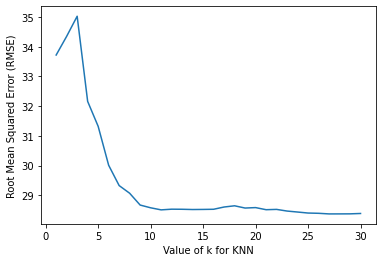

In [90]:
#Plot the value of k for KNN (x-axis) versus the RMSE (y-axis)
plt.plot(k_range, k_rmses)
plt.xlabel('Value of k for KNN')
plt.ylabel('Root Mean Squared Error (RMSE)')

Let's run our model again using GridSearch Cross Validation.

# Grid Search CV Parameter Optimization

In [91]:
#Create a parameter grid of the k values to search
param_grid = dict(n_neighbors=k_range)
print(param_grid)

{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]}


In [92]:
grid = GridSearchCV(knn, param_grid, scoring='neg_root_mean_squared_error') #Instantiate the grid
grid.fit(X_train, y_train)

GridSearchCV(estimator=KNeighborsRegressor(n_neighbors=30, weights='distance'),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30]},
             scoring='neg_root_mean_squared_error')

In [93]:
#View the results
grid.cv_results_

{'mean_fit_time': array([0.02258825, 0.02281947, 0.02320499, 0.02218127, 0.02238073,
        0.02238274, 0.02209702, 0.02004542, 0.02319293, 0.02339435,
        0.02318325, 0.02438359, 0.02460923, 0.02382441, 0.02440319,
        0.02362881, 0.0243968 , 0.02402325, 0.02359872, 0.02360563,
        0.02298198, 0.0215795 , 0.02401185, 0.02261605, 0.02262616,
        0.02261424, 0.02360897, 0.01931033, 0.02361393, 0.02260566]),
 'std_fit_time': array([0.00287159, 0.001114  , 0.00076433, 0.00076939, 0.00136311,
        0.00134372, 0.00091853, 0.00403956, 0.00101462, 0.00049027,
        0.00172168, 0.00050349, 0.0014797 , 0.00037885, 0.00515883,
        0.00078024, 0.00051889, 0.00087468, 0.00101873, 0.00080796,
        0.00058127, 0.00298388, 0.00303   , 0.00049967, 0.00048751,
        0.00047546, 0.00137915, 0.00441275, 0.0007837 , 0.00084007]),
 'mean_score_time': array([0.42578268, 0.44535542, 0.4498107 , 0.45462008, 0.44744253,
        0.44462328, 0.45830398, 0.40291166, 0.45939784, 0.46

In [94]:
#View the results in a dataframe
grid_df = pd.DataFrame(grid.cv_results_)
grid_df.head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.022588,0.002872,0.425783,0.029611,1,{'n_neighbors': 1},-35.262171,-34.604185,-53.063021,-32.314169,-34.527320,-37.954173,7.619705,30
1,0.022819,0.001114,0.445355,0.035675,2,{'n_neighbors': 2},-36.969367,-39.633619,-39.940937,-33.559681,-38.233205,-37.667362,2.311525,29
2,0.023205,0.000764,0.449811,0.013741,3,{'n_neighbors': 3},-35.871627,-36.697969,-33.195935,-32.795071,-35.201637,-34.752448,1.516143,28
3,0.022181,0.000769,0.454620,0.019108,4,{'n_neighbors': 4},-32.825083,-33.473399,-37.168027,-30.206186,-32.895067,-33.313552,2.233919,27
4,0.022381,0.001363,0.447443,0.007757,5,{'n_neighbors': 5},-32.422655,-32.578794,-34.352941,-29.212822,-31.942038,-32.101850,1.659508,26


In [95]:
#Obtain columns of interest
grid_df = grid_df[['mean_test_score', 'std_test_score', 'params']]
grid_df.head(3)

,mean_test_score,std_test_score,params
0,-37.954173,7.619705,{'n_neighbors': 1}
1,-37.667362,2.311525,{'n_neighbors': 2}
2,-34.752448,1.516143,{'n_neighbors': 3}


In [96]:
#Print the array of mean RMSEs
grid_mean_rmses = grid.cv_results_['mean_test_score']
print(grid_mean_rmses)

[-37.95417307 -37.6673618  -34.75244767 -33.31355241 -32.10185013
 -31.57999129 -31.0983663  -30.65572275 -30.57825301 -30.23848723
 -30.07105405 -29.83660266 -29.79881745 -29.71934391 -29.69798368
 -29.66855843 -29.75908184 -29.92784953 -29.85863057 -29.79072493
 -29.74175752 -29.75296847 -29.70594526 -29.64968203 -29.60930445
 -29.59984226 -29.57257354 -29.56589187 -29.5691595  -29.5543388 ]


Text(0, 0.5, 'Cross Validated Mean RMSE')

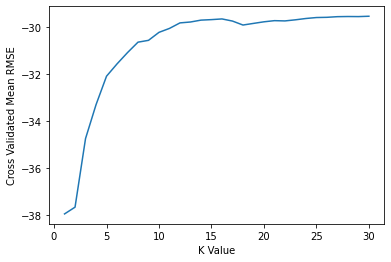

In [97]:
#Plot k vs the mean RMSEs
plt.plot(k_range, grid_mean_rmses)
plt.xlabel('K Value')
plt.ylabel('Cross Validated Mean RMSE')

In [98]:
#Obtain the best model and its parameters
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

-29.554338800800046
{'n_neighbors': 30}
KNeighborsRegressor(n_neighbors=30, weights='distance')


The best model was obtained with the largest k_value we tested (k=30). This suggests that the model has not reached optimization. Thus we will reoptimize using higher k values.

In [99]:
k_range = list(range(30, 300, 10))
param_grid = dict(n_neighbors=k_range)
grid = GridSearchCV(knn, param_grid, scoring='neg_root_mean_squared_error') #Instantiate the grid
grid.fit(X_train, y_train)
grid_df = pd.DataFrame(grid.cv_results_)
grid_df.head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.024899,0.002356,0.516685,0.046258,30,{'n_neighbors': 30},-31.551302,-29.666522,-29.502692,-27.635166,-29.416012,-29.554339,1.241408,27
1,0.022773,0.000777,0.485465,0.013304,40,{'n_neighbors': 40},-31.441889,-29.537217,-29.406181,-27.629189,-29.495518,-29.501999,1.206736,26
2,0.023215,0.001490,0.552691,0.095861,50,{'n_neighbors': 50},-31.497198,-29.463864,-29.412282,-27.637606,-29.463873,-29.494965,1.222087,25
3,0.019733,0.004344,0.443455,0.048263,60,{'n_neighbors': 60},-31.457031,-29.489627,-29.392238,-27.615351,-29.419477,-29.474745,1.216296,24
4,0.023185,0.000753,0.527300,0.024545,70,{'n_neighbors': 70},-31.309147,-29.473516,-29.381073,-27.664548,-29.421331,-29.449923,1.153290,23


In [100]:
#Obtain columns of interest
grid_df = grid_df[['mean_test_score', 'std_test_score', 'params']]
grid_df.head(3)

,mean_test_score,std_test_score,params
0,-29.554339,1.241408,{'n_neighbors': 30}
1,-29.501999,1.206736,{'n_neighbors': 40}
2,-29.494965,1.222087,{'n_neighbors': 50}


In [101]:
#Print the array of mean RMSEs
grid_mean_rmses = grid.cv_results_['mean_test_score']
print(grid_mean_rmses)

[-29.5543388  -29.50199887 -29.4949646  -29.47474487 -29.44992276
 -29.44430617 -29.42613953 -29.42571446 -29.40164488 -29.40213701
 -29.40365469 -29.39457839 -29.40115757 -29.39767791 -29.39651134
 -29.39863557 -29.39409333 -29.40290601 -29.40490432 -29.39772654
 -29.40938313 -29.41592477 -29.40006498 -29.38719237 -29.38779993
 -29.39119439 -29.3862549 ]


In [102]:
#Obtain the best model and its parameters
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

-29.38625490235133
{'n_neighbors': 290}
KNeighborsRegressor(n_neighbors=290, weights='distance')


Let's make a prediction using our optimal kNeighborsRegressor model.

In [103]:
knn = KNeighborsRegressor(n_neighbors=290, weights='distance').fit(X_train, y_train)
y_pred = knn.predict(X_test) #make a prediction using our test set

In [104]:
knn_rmse = (mean_squared_error(y_test, y_pred, squared=False)) #RMSE
knn_rmse

28.29841270796276

# Simultaneous Grid Search for Multiple Models

In [105]:
#Instantiate the models to be used in grid search CV
reg1 = DecisionTreeRegressor(min_samples_split=10, random_state=42)
reg2 = RandomForestRegressor(min_samples_split=10, random_state=42)

In [106]:
#Create the parameter dictionary for the regressions
param1 = {}
param1['regressor'] = [reg1]

param2 = {}
param2['regressor'] = [reg2]

In [107]:
pipe = Pipeline(
    [
     ('regressor', reg1)
    ]
)

params = [param1, param2]

In [108]:
#Use GridSearchCV to search every parameter combination within each dictionary
grid = GridSearchCV(pipe, params, scoring='neg_root_mean_squared_error').fit(X_train, y_train)
grid.best_params_

{'regressor': DecisionTreeRegressor(min_samples_split=10, random_state=42)}

Now we will find hyperparameters for the SVR model.

In [109]:
param_grid = [{'kernel': ["linear", "poly", "rbf", "sigmoid"]}]

svr_reg = SVR()
grid = GridSearchCV(svr_reg, param_grid, scoring='neg_root_mean_squared_error').fit(X_train, y_train)
grid.best_params_

{'kernel': 'linear'}

In [110]:
param_grid = [
    {'kernel': ["linear"],
     'degree': [0, 1, 3]}
]

svr_reg = SVR()
grid = GridSearchCV(svr_reg, param_grid, scoring='neg_root_mean_squared_error').fit(X_train, y_train)
grid.best_params_

{'degree': 0, 'kernel': 'linear'}

In [111]:
param_grid = [
    {'kernel': ["linear"],
     'degree': [0],
     'gamma': ['scale', 'auto']}
]

svr_reg = SVR()
grid = GridSearchCV(svr_reg, param_grid, scoring='neg_root_mean_squared_error').fit(X_train, y_train)
grid.best_params_

{'degree': 0, 'gamma': 'scale', 'kernel': 'linear'}

In [112]:
param_grid = [
    {'kernel': ["linear"],
     'degree': [0],
     'gamma': ['scale'],
     'C': [0.25, 0.5, 1]}
]

svr_reg = SVR()
grid = GridSearchCV(svr_reg, param_grid, scoring='neg_root_mean_squared_error').fit(X_train, y_train)
grid.best_params_

{'C': 0.25, 'degree': 0, 'gamma': 'scale', 'kernel': 'linear'}

A good hyperparameter SVR model has the above parameters. We'll compare this model with the decision tree and see which one is better.

In [113]:
#Instantiate models to be used in grid search CV
reg1 = DecisionTreeRegressor(min_samples_split=10, random_state=42)
reg2 = SVR(kernel="linear", degree=0, gamma='scale', C=0.25)

#Create parameter dictionary for the regressions
param1 = {}
param1['regressor'] = [reg1]

param2 = {}
param2['regressor'] = [reg2]

#Create the pipeline
pipe = Pipeline(
    [
     ('regressor', reg1)
    ]
)

params = [param1, param2]

grid = GridSearchCV(pipe, params, scoring='neg_root_mean_squared_error').fit(X_train, y_train)
grid.best_params_

{'regressor': DecisionTreeRegressor(min_samples_split=10, random_state=42)}

The best model for this dataset is the decision tree regressor.
Let's make a prediction using our test data and get the RMSE for this model.

In [114]:
#Make prediction using the test set
dt = DecisionTreeRegressor(min_samples_split=10, random_state=42).fit(X_train, y_train)
y_pred = dt.predict(X_test)

dt_rmse = (mean_squared_error(y_test, y_pred, squared=False)) #RMSE
dt_rmse

28.246489096196914

In [115]:
df=pd.DataFrame({'y_test':y_test, 'y_pred':y_pred, 'Difference': y_test - y_pred})
sorted_df = df.sort_values(by='Difference', ascending=True)
sorted_df

,y_test,y_pred,Difference
2624,25.987,85.047197,-59.060197
27703,29.887,85.047197,-55.160197
32757,20.787,73.934853,-53.147853
10812,23.387,73.934853,-50.547853
18924,35.607,85.047197,-49.440197
...,...,...,...
23784,289.055,27.445150,261.609850
19412,324.935,48.145676,276.789324
26975,363.935,48.145676,315.789324
31567,363.935,48.145676,315.789324


<AxesSubplot:>

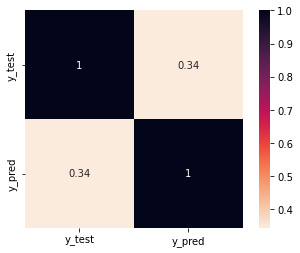

In [116]:
cor = sorted_df[['y_test','y_pred']].corr() #Calculate the correlation of test and predicted prices
cmap = sns.cm.rocket_r
sns.heatmap(cor, square = True, annot=True, cmap=cmap) #Plot the correlation as a heat map

In [117]:
X.head(3)

,broad_desc,gender
0,27.535409,32.164366
1,48.144429,32.164366
2,27.000670,30.989396


The test and predicted prices are not strongly correlated for the decision tree model.

<AxesSubplot:>

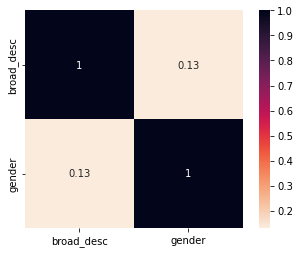

In [118]:
cor = X.corr() #Calculate the correlation of the features
cmap = sns.cm.rocket_r
sns.heatmap(cor, square = True, annot=True, cmap=cmap) #Plot the correlation as heat map

Just looking at the features themsleves (no modeling) they are not strongly correlated.

## Conclusion

Of the various models in this supervised learning task, decision tree yielded the best results. However, upon making predictions, this showed to be a weak model. It should be noted that the decision tree model is better (RMSE=28) than the baseline model (RMSE=32). With more information on the clothing articles, customer demographics, and etc., it is possible to do further feature engineering in order to obtain a better model.